# German License Plate Recognition Workflow
This notebook demonstrates the complete workflow of license plate detection and the subsequent recognition of the license number, as it has to be done later in the Android app.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

from distutils.version import StrictVersion
from PIL import Image

In [2]:
print ("Tensorflow: {}".format(tf.__version__))

if StrictVersion(tf.__version__.split('-')[0]) < StrictVersion('2.4.0'):
    raise ImportError('Please upgrade your TensorFlow installation to v2.4.0')

if StrictVersion(tf.__version__.split('-')[0]) >= StrictVersion('3.0.0'):
    raise ImportError('Please downgrade your TensorFlow installation to v3.4.*.')

device_name = tf.test.gpu_device_name()

if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")

print(f"GPU device: {device_name}")

Tensorflow: 2.4.0
GPU device: /device:GPU:0


In [3]:
from config.license_recognition import config

DETECTION_MODEL_NAME = 'glpd-model.tflite'
RECOGNITION_MODEL_NAME = 'glpr-model.tflite'

OUTPUT_DIR = 'output'
DETECTION_MODEL_PATH = os.path.join(OUTPUT_DIR, 'plate_detection', DETECTION_MODEL_NAME)
RECOGNITION_MODEL_PATH = os.path.join(OUTPUT_DIR, 'license_recognition', RECOGNITION_MODEL_NAME)
TEST_IMAGES = 'data/license_recognition/test_images'

print("Output Directory:       {}".format(OUTPUT_DIR))
print("Detection Model Path:   {}".format(DETECTION_MODEL_PATH))
print("Recognition Model Path: {}".format(RECOGNITION_MODEL_PATH))
print("Test Images Path:       {}".format(TEST_IMAGES))

Output Directory:       output
Detection Model Path:   output\plate_detection\glpd-model.tflite
Recognition Model Path: output\license_recognition\glpr-model.tflite
Test Images Path:       data/license_recognition/test_images


# Workflow
First we load the file paths of the test images into an array.

In [4]:
# number of samples to test; -1 <=> all
NUM_SAMPLES = -1

PATH_TO_TEST_IMAGES_DIR = 'data/plate_detection/test_images'

In [5]:
import glob

TEST_IMAGE_PATHS = []
for filename in glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg')):
    TEST_IMAGE_PATHS.append(filename)
    
print ('{} test images:'.format(len(TEST_IMAGE_PATHS)))

if NUM_SAMPLES > 0:
    test_images = np.random.choice(TEST_IMAGE_PATHS, size = NUM_SAMPLES, replace=False)
else:
    test_images = TEST_IMAGE_PATHS

print (test_images)

31 test images:
['data/plate_detection/test_images\\A-CR655.jpg', 'data/plate_detection/test_images\\A-MB1012.jpg', 'data/plate_detection/test_images\\B-EG773E.jpg', 'data/plate_detection/test_images\\B-GN420.jpg', 'data/plate_detection/test_images\\BC-07129.jpg', 'data/plate_detection/test_images\\BL-XY9999.jpg', 'data/plate_detection/test_images\\CW-KO222.jpg', 'data/plate_detection/test_images\\DEG-FE41E.jpg', 'data/plate_detection/test_images\\F-JU10.jpg', 'data/plate_detection/test_images\\FC241ZH.jpg', 'data/plate_detection/test_images\\FÜ-SZ262.jpg', 'data/plate_detection/test_images\\GG-XN761.jpg', 'data/plate_detection/test_images\\HB-01199.jpg', 'data/plate_detection/test_images\\HH-CZ3874.jpg', 'data/plate_detection/test_images\\HI-JO500.jpg', 'data/plate_detection/test_images\\K-OE2037.jpg', 'data/plate_detection/test_images\\K-QZ1192.jpg', 'data/plate_detection/test_images\\K-ZE1008E.jpg', 'data/plate_detection/test_images\\LB-C6CYE.jpg', 'data/plate_detection/test_images\

With the parameter 'IMG_INDEX' we define the test image we want to use for the test run. Then we display the picture.

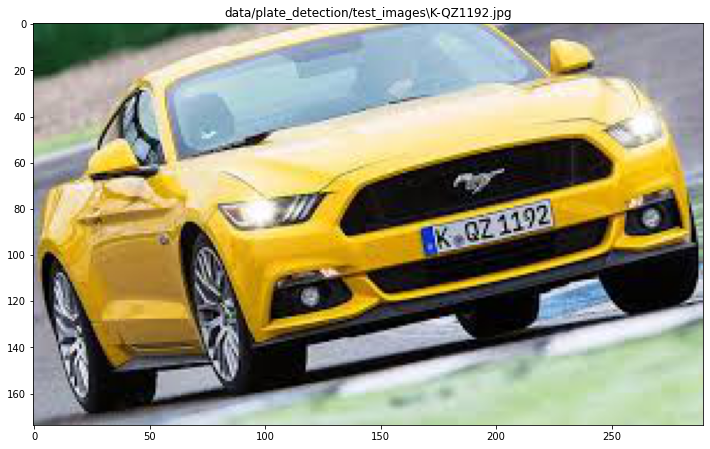

In [6]:
IMG_INDEX = 16

image_path = TEST_IMAGE_PATHS[IMG_INDEX]

plt.figure(figsize=(12, 12))
plt.title(image_path)
plt.imshow(Image.open(image_path))
plt.show()

In the first step we perform an inference with the License Plate Detection model, this gives us the image section containing the license plate and let us display the corresponding image section.

In [7]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

Box: [0.43657187 0.5761821  0.587137   0.77777433]
Class: 0
Score: 0.9927515983581543
Detections: 1


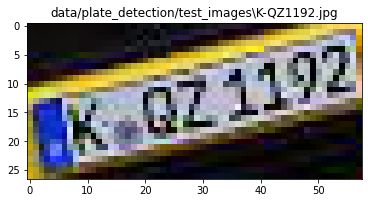

In [8]:
from object_detection.utils import visualization_utils as vis_util
from PIL import ImageOps

%matplotlib inline 

input_mean = 127.5
input_std = 127.5

interpreter = tf.lite.Interpreter(model_path=DETECTION_MODEL_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']
output_shape = output_details[0]['shape']

image = Image.open(image_path)
image_np = load_image_into_numpy_array(image.resize((300, 300), Image.ANTIALIAS))
input_data = np.array(np.expand_dims(image_np, axis=0), dtype=np.float32)
input_data = (np.float32(input_data) - input_mean) / input_std

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

detection_box = np.squeeze(interpreter.tensor(output_details[0]['index'])())
print("Box: {}".format(detection_box))

detection_class = np.squeeze(interpreter.tensor(output_details[1]['index'])()).astype(np.uint8)
print("Class: {}".format(detection_class))

detection_score = np.squeeze(interpreter.tensor(output_details[2]['index'])())
print("Score: {}".format(detection_score))

num_detections = np.squeeze(interpreter.tensor(output_details[3]['index'])()).astype(int)
print("Detections: {}".format(num_detections))

if num_detections > 0 and detection_score > 0.5: 
    image_np = load_image_into_numpy_array(image)
    ymin, xmin, ymax, xmax = detection_box

    #vis_util.draw_bounding_box_on_image_array(image_np, ymin, xmin, ymax, xmax, color='red', thickness=1)            
    
    x1 = int(xmin * image_np.shape[1])
    x2 = int(xmax * image_np.shape[1])
    y1 = int(ymin * image_np.shape[0])
    y2 = int(ymax * image_np.shape[0])

    plate_img = image_np[y1:y2, x1:x2]

    plt.figure(figsize=(6, 6))
    plt.title(image_path)
    plt.imshow(plate_img)
    plt.show()

In the second step, we perform an inference with the License Reginition model, passing the image section with the recognized license plate from the previous step. This returns the license plate recognized in the image in plain text.

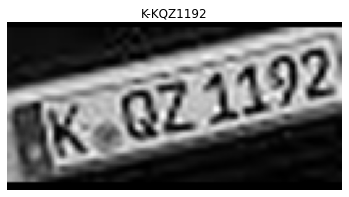

In [9]:
from config.license_recognition import config
from label_codec import LabelCodec
from utils.preprocessing import AspectAwarePreprocessor

if not 'plate_img' in locals():
    raise SystemError("plate_image not defined!")

preprocessor = AspectAwarePreprocessor(config.IMAGE_WIDTH, config.IMAGE_HEIGHT)

image = preprocessor.preprocess(Image.fromarray(plate_img))
image = image.astype(np.float32) / 255.
image = np.expand_dims(image.T, axis=-1)

interpreter = tf.lite.Interpreter(model_path=RECOGNITION_MODEL_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']
output_shape = output_details[0]['shape']

interpreter.set_tensor(input_details[0]['index'], np.asarray([image]))
interpreter.invoke()
predictions = interpreter.get_tensor(output_details[0]['index'])

label = LabelCodec.decode_prediction(predictions[0])

plt.axis("off")
plt.title(label)
plt.imshow(image[:, :, 0].T, cmap='gray')
plt.show()